In [1]:
#conda install pytorch torchvision -c pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import imblearn as imb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader
from imblearn.over_sampling import RandomOverSampler
from google.colab import drive

In [33]:
drive.mount('/content/drive')

X_train = np.load('/content/drive/MyDrive/Colab Notebooks/Machine learning/Xtrain1.npy')
y_train = np.load('/content/drive/MyDrive/Colab Notebooks/Machine learning/Ytrain1.npy')
X_test = np.load('/content/drive/MyDrive/Colab Notebooks/Machine learning/Xtest1.npy')
X_train1_extra = np.load('/content/drive/MyDrive/Colab Notebooks/Machine learning/Xtrain1_extra.npy')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Pre-processing

# Image processing

In [79]:
im = X_train.reshape(X_train.shape[0],48,48)

new = im.copy()

threshold = 200
for sample in range(im.shape[0]):

  # Oustanding boundaries
  for i in range(im.shape[1]):
      for j in range(im.shape[2]):
          if (im[sample][i][j] > threshold) | (im[sample][i][j] < 50):
              new[sample][i][j] = 255
          else:
              new[sample][i][j] = 0

  # Removing isolated pixels
  for i in range(new.shape[1]):
      for j in range(new.shape[2]):
          if new[sample][i][j] == 255:
              if (i>0) and (j>0) and (i<new.shape[1]-1) and (j<new.shape[2]-1):
                  if ((new[sample][i-1][j]==0) and (new[sample][i+1][j]==0) and
                      (new[sample][i][j-1]==0) and (new[sample][i][j+1]==0) and
                      (new[sample][i-1][j-1]==0) and (new[sample][i-1][j+1]==0) and
                      (new[sample][i+1][j-1]==0) and (new[sample][i+1][j+1]==0)):

                        new[sample][i][j] = 0

  #m = im.imshow(im,cmap='gray')
  #im = im(as_grey=True)
  #new = filters.gaussian(new,sigma=0.5)  # Ajusta sigma para controlar el nivel de suavizado
  #new= filters.median(new)  # Ajusta sigma para controlar el nivel de suavizado
  #image_gaussian = feature.canny(im, sigma=3)  # Ajusta sigma según el nivel de detección de bordes


Verifying if pre-process has been succesful:


1


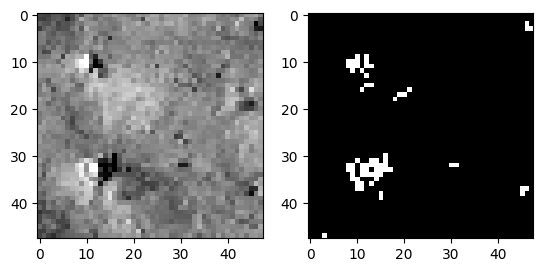

In [80]:
fig, ax = plt.subplots(1,2)
picture = 3
ax[0].imshow(im[picture], cmap='gray')
ax[1].imshow(new[picture], cmap='gray')
print(y_train[picture])

We need to reshape the images again into linear vectors to be used in the following section:

In [87]:
X_train_processed = new.reshape(new.shape[0], -1)

Let's verify if it has been done properly:

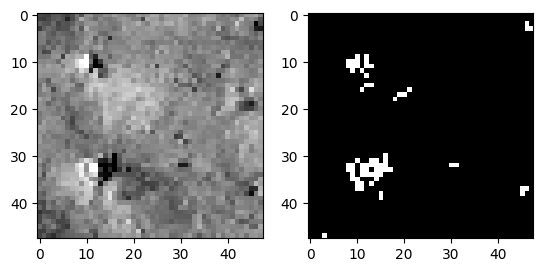

In [92]:
im_val = X_train_processed.reshape(X_train_processed.shape[0],48,48)

fig, ax = plt.subplots(1,2)
ax[0].imshow(im[picture], cmap='gray')
ax[1].imshow(im_val[picture], cmap='gray')


## Data Imbalance

In [93]:
print("The number of training samples with class 0 :", np.sum(y_train==0))
print("The number of training samples with class 1 :", np.sum(y_train==1))
print("The percentage of training samples with class 0 :", np.sum(y_train==0)/np.sum(y_train==1))

The number of training samples with class 0 : 1006
The number of training samples with class 1 : 1777
The percentage of training samples with class 0 : 0.566122678671919


### Random over-sampling

In [94]:
ros = imb.over_sampling.RandomOverSampler(random_state=None)

X_train_ROS, y_train_ROS = ros.fit_resample(X_train_processed, y_train)
X_train_ROS, X_val_ROS, y_train_ROS, y_val_ROS = train_test_split(X_train_ROS, y_train_ROS, test_size=0.2)
print("The number of training samples with class 0 after ROS :", np.sum(y_train_ROS==0))
print("The number of training samples with class 1 after ROS :", np.sum(y_train_ROS==1))

The number of training samples with class 0 after ROS : 1433
The number of training samples with class 1 after ROS : 1410


# Preparing the data to be used in the neural tetwork:

In [97]:
X_train_valanced = X_train_ROS.reshape(X_train_ROS.shape[0],48,48)
X_val_valanced = X_val_ROS.reshape(X_val_ROS.shape[0],48,48)

X_train_normalized = (X_train_valanced / 255.0).astype(np.float32)  # Tensors only admit normalized float data
X_val_normalized = (X_val_valanced / 255.0).astype(np.float32)

X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
X_train_tensor = X_train_tensor.unsqueeze(1)  # We add a dimension to be used in the neural network
X_val_tensor = torch.tensor(X_val_normalized, dtype=torch.float32)
X_val_tensor = X_val_tensor.unsqueeze(1)

y_train_tensor = torch.tensor(y_train_ROS, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_ROS, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)


# Neural network

Definition of the net:

In [98]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
         # Layers creation
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2) #Padding = kernel_size//2
        self.mp1 = nn.MaxPool2d(2) # Reduces the dimensions of the layer by getting the important value
        self.conv2 = nn.Conv2d(6, 16, 5, padding=2)
        self.mp2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(16, 120, 3, padding=1)
        self.fc1 = nn.Linear(12*12*120, 256) # Reduces the dimension of the features
        self.fc2 = nn.Linear(256, 2) # Output layer, with only a

    def forward(self, x):
       # Backpropagation of the error
        x = F.relu(self.conv1(x)) # Activation funtion
        x = self.mp1(x)
        x = F.relu(self.conv2(x))
        x = self.mp2(x)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 12*12*120)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x)) # Activation funtion at the output
        return x

Definition of the loss function and optimizer:

In [99]:
model = LeNet()
criterion = nn.CrossEntropyLoss() # Loss funtion
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #Learning rate and momentum
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=17280, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

Intermediate tests:

In [100]:
x1 = X_train_tensor # 2783 pictures 48x48
x2 = model.conv1(x1) # For each picture we'll obtain 6 of 48x48, one for each kernel
x3 = model.mp1(x2) # Each of the 6 are reduced by half
x4 = model.conv2(x3) # Repeat
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)

torch.Size([2843, 1, 48, 48])
torch.Size([2843, 6, 48, 48])
torch.Size([2843, 6, 24, 24])
torch.Size([2843, 16, 24, 24])


Training:

Train
>>> Epoch 0 >>>> Loss: 0.013856583672260845, Acc: 0.547309160232544
Train
>>> Epoch 1 >>>> Loss: 0.013516783923948478, Acc: 0.6049947142601013
Train
>>> Epoch 2 >>>> Loss: 0.012027289156254605, Acc: 0.7404150366783142
Train
>>> Epoch 3 >>>> Loss: 0.011047266714597227, Acc: 0.7492085695266724
Train
>>> Epoch 4 >>>> Loss: 0.010871277019418212, Acc: 0.7632782459259033
Train
>>> Epoch 5 >>>> Loss: 0.010865486301337587, Acc: 0.7597607970237732
Train
>>> Epoch 6 >>>> Loss: 0.01087804058467759, Acc: 0.7618712782859802
Train
>>> Epoch 7 >>>> Loss: 0.010755504410408602, Acc: 0.7646852135658264
Train
>>> Epoch 8 >>>> Loss: 0.010713109658127556, Acc: 0.7699612975120544
Train
>>> Epoch 9 >>>> Loss: 0.010661620008580668, Acc: 0.7741822004318237
Train
>>> Epoch 10 >>>> Loss: 0.010619331299315193, Acc: 0.7759408950805664
Train
>>> Epoch 11 >>>> Loss: 0.010591831250883432, Acc: 0.7776995897293091
Train
>>> Epoch 12 >>>> Loss: 0.010551031106297416, Acc: 0.7812170386314392
Train
>>> Epoch 13 >>>> 

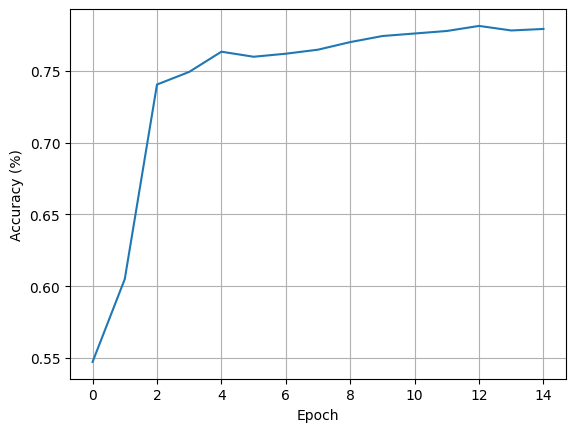

In [101]:
n_epochs = 15

accuracy = torch.zeros(n_epochs) #if it fails change 3 * "accuracy" by "ajuste"

for epoch in range(n_epochs):
    print("Train")
    running_loss = 0.0 # Loss of each epoch
    running_acc = 0.0 # Accuracy of each epoch
    total = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        total += labels.shape[0]
        # Gradients inicialization
        optimizer.zero_grad()

        # forward + backward + optimizar
        outputs = model(images) # Forward-pass
        loss = criterion(outputs, labels) # Loss computing
        loss.backward()# Backward pass
        optimizer.step() # Optimization

        # Estatistics
        running_loss += loss.item() # Total loss of the current batch
        # extraemos las etiquetas que predice (nº neurona con máxima probabilidad)
        _, predicted = torch.max(outputs, 1)
        running_acc += torch.sum(predicted==labels) # Number of correct predictions
    accuracy[epoch]=running_acc/total
    print(f'>>> Epoch {epoch} >>>> Loss: {running_loss/total}, Acc: {running_acc/total}')
    #scheduler.step() #Decreasing learning rate

plt.plot(range(n_epochs), accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)